In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import copy
from tqdm import tqdm

# Import SBEOS_Environment from the provided code
# (assuming the environment code is already imported)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[128, 64]):
        super(DQN, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, 
                 epsilon_min=0.01, epsilon_decay=0.995, buffer_size=10000, batch_size=64,
                 update_target_freq=100):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.update_target_freq = update_target_freq
        self.buffer = ReplayBuffer(buffer_size)
        
        # Create Q networks
        self.q_network = DQN(state_dim, action_dim)
        self.target_network = copy.deepcopy(self.q_network)
        
        # Initialize optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # For tracking updates
        self.update_counter = 0
    
    def get_action(self, state, training=True):
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()
    
    def train(self):
        if len(self.buffer) < self.batch_size:
            return 0
        
        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        # Compute current Q values
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q values
        with torch.no_grad():
            next_q = self.target_network(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss and update
        loss = F.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network periodically
        self.update_counter += 1
        if self.update_counter % self.update_target_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()
    
    def save_model(self, path):
        torch.save(self.q_network.state_dict(), path)
    
    def load_model(self, path):
        self.q_network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(self.q_network.state_dict())

def train_dqn(env, agent, num_episodes=1000, max_steps=None, eval_freq=10):
    """Train the DQN agent and return training history."""
    if max_steps is None:
        max_steps = env.max_timesteps
    
    # Metrics tracking
    episode_rewards = []
    episode_accuracies = []
    episode_energy_consumption = []
    eval_rewards = []
    eval_accuracies = []
    eval_energy_consumption = []
    
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        episode_reward = 0
        correct_predictions = 0
        total_predictions = 0
        energy_spent = 0
        
        for step in range(max_steps):
            # Select action
            action = agent.get_action(state)
            
            # Take action
            next_state, reward, done, info = env.step(action)
            
            # Store experience
            agent.buffer.add(state, action, reward, next_state, done)
            
            # Train agent
            agent.train()
            
            # Update metrics
            episode_reward += reward
            energy_cost = info["energy_cost"]
            energy_spent += energy_cost
            
            # Track prediction accuracy (based on returned reward)
            # Assuming reward > 0 means correct prediction
            if reward > 0:
                correct_predictions += 1
            total_predictions += 1
            
            # Move to next state
            state = next_state
            
            if done:
                break
        
        # Calculate episode accuracy
        episode_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        # Store episode metrics
        episode_rewards.append(episode_reward)
        episode_accuracies.append(episode_accuracy)
        episode_energy_consumption.append(energy_spent)
        
        # Periodic evaluation
        if (episode + 1) % eval_freq == 0:
            eval_reward, eval_accuracy, eval_energy = evaluate_agent(env, agent)
            eval_rewards.append(eval_reward)
            eval_accuracies.append(eval_accuracy)
            eval_energy_consumption.append(eval_energy)
            
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Training: Reward={episode_reward:.2f}, Accuracy={episode_accuracy:.2f}, Energy={energy_spent:.2f}")
            print(f"  Evaluation: Reward={eval_reward:.2f}, Accuracy={eval_accuracy:.2f}, Energy={eval_energy:.2f}")
    
    # Final evaluation
    final_eval_reward, final_eval_accuracy, final_eval_energy = evaluate_agent(env, agent)
    
    # Return training history
    history = {
        "train_rewards": episode_rewards,
        "train_accuracies": episode_accuracies,
        "train_energy": episode_energy_consumption,
        "eval_rewards": eval_rewards,
        "eval_accuracies": eval_accuracies,
        "eval_energy": eval_energy_consumption,
        "final_eval_reward": final_eval_reward,
        "final_eval_accuracy": final_eval_accuracy,
        "final_eval_energy": final_eval_energy
    }
    
    return history

def evaluate_agent(env, agent, num_episodes=5):
    """Evaluate the agent without exploration."""
    total_rewards = []
    total_accuracies = []
    total_energy = []
    
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        correct_predictions = 0
        total_predictions = 0
        energy_spent = 0
        
        done = False
        while not done:
            action = agent.get_action(state, training=False)  # No exploration
            next_state, reward, done, info = env.step(action)
            
            episode_reward += reward
            energy_cost = info["energy_cost"]
            energy_spent += energy_cost
            
            if reward > 0:
                correct_predictions += 1
            total_predictions += 1
            
            state = next_state
        
        episode_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        total_rewards.append(episode_reward)
        total_accuracies.append(episode_accuracy)
        total_energy.append(energy_spent)
    
    return np.mean(total_rewards), np.mean(total_accuracies), np.mean(total_energy)

def plot_training_results(history, save_path=None):
    """Plot training and evaluation metrics."""
    fig, axs = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot rewards
    axs[0].plot(history["train_rewards"], label='Training')
    axs[0].plot(np.arange(0, len(history["train_rewards"]), len(history["train_rewards"])//len(history["eval_rewards"]))[:len(history["eval_rewards"])], 
                history["eval_rewards"], label='Evaluation')
    axs[0].set_title('Episode Rewards')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot accuracies
    axs[1].plot(history["train_accuracies"], label='Training')
    axs[1].plot(np.arange(0, len(history["train_accuracies"]), len(history["train_accuracies"])//len(history["eval_accuracies"]))[:len(history["eval_accuracies"])], 
                history["eval_accuracies"], label='Evaluation')
    axs[1].set_title('Prediction Accuracy')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    
    # Plot energy consumption
    axs[2].plot(history["train_energy"], label='Training')
    axs[2].plot(np.arange(0, len(history["train_energy"]), len(history["train_energy"])//len(history["eval_energy"]))[:len(history["eval_energy"])], 
                history["eval_energy"], label='Evaluation')
    axs[2].set_title('Energy Consumption')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Energy')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    
    # Print final evaluation metrics
    print(f"Final Evaluation Metrics:")
    print(f"  Reward: {history['final_eval_reward']:.2f}")
    print(f"  Accuracy: {history['final_eval_accuracy']:.2f}")
    print(f"  Energy Consumption: {history['final_eval_energy']:.2f}")

Initializing SBEOS environment...
State dimension: 16, Action dimension: 4
Training DQN on SBEOS environment...


  4%|▍         | 20/500 [00:05<02:58,  2.68it/s]

Episode 20/500
  Training: Reward=1340.00, Accuracy=0.78, Energy=893.00
  Evaluation: Reward=1464.00, Accuracy=0.82, Energy=483.60


  8%|▊         | 40/500 [00:11<02:52,  2.66it/s]

Episode 40/500
  Training: Reward=1265.00, Accuracy=0.76, Energy=1001.00
  Evaluation: Reward=1401.00, Accuracy=0.80, Energy=541.20


 12%|█▏        | 60/500 [00:16<02:43,  2.70it/s]

Episode 60/500
  Training: Reward=1550.00, Accuracy=0.85, Energy=902.00
  Evaluation: Reward=1539.00, Accuracy=0.84, Energy=775.20


 16%|█▌        | 80/500 [00:22<02:35,  2.71it/s]

Episode 80/500
  Training: Reward=1010.00, Accuracy=0.67, Energy=992.00
  Evaluation: Reward=1383.00, Accuracy=0.79, Energy=1583.40


 20%|██        | 100/500 [00:27<02:25,  2.74it/s]

Episode 100/500
  Training: Reward=1370.00, Accuracy=0.79, Energy=1046.00
  Evaluation: Reward=1230.00, Accuracy=0.74, Energy=818.40


 24%|██▍       | 120/500 [00:33<02:20,  2.70it/s]

Episode 120/500
  Training: Reward=365.00, Accuracy=0.46, Energy=767.00
  Evaluation: Reward=1200.00, Accuracy=0.73, Energy=1324.20


 28%|██▊       | 140/500 [00:38<02:14,  2.68it/s]

Episode 140/500
  Training: Reward=710.00, Accuracy=0.57, Energy=1100.00
  Evaluation: Reward=1491.00, Accuracy=0.83, Energy=1691.40


 32%|███▏      | 160/500 [00:44<02:07,  2.67it/s]

Episode 160/500
  Training: Reward=920.00, Accuracy=0.64, Energy=1199.00
  Evaluation: Reward=1074.00, Accuracy=0.69, Energy=1939.80


 36%|███▌      | 180/500 [00:50<02:02,  2.62it/s]

Episode 180/500
  Training: Reward=1085.00, Accuracy=0.69, Energy=1181.00
  Evaluation: Reward=1200.00, Accuracy=0.73, Energy=1169.40


 40%|████      | 200/500 [00:55<01:50,  2.73it/s]

Episode 200/500
  Training: Reward=1460.00, Accuracy=0.82, Energy=1001.00
  Evaluation: Reward=1221.00, Accuracy=0.74, Energy=615.00


 44%|████▍     | 220/500 [01:01<01:42,  2.73it/s]

Episode 220/500
  Training: Reward=1355.00, Accuracy=0.79, Energy=1307.00
  Evaluation: Reward=1296.00, Accuracy=0.76, Energy=1077.60


 48%|████▊     | 240/500 [01:07<01:38,  2.63it/s]

Episode 240/500
  Training: Reward=890.00, Accuracy=0.63, Energy=848.00
  Evaluation: Reward=1314.00, Accuracy=0.77, Energy=589.80


 52%|█████▏    | 260/500 [01:12<01:30,  2.66it/s]

Episode 260/500
  Training: Reward=860.00, Accuracy=0.62, Energy=1199.00
  Evaluation: Reward=1077.00, Accuracy=0.69, Energy=1331.40


 56%|█████▌    | 280/500 [01:18<01:21,  2.71it/s]

Episode 280/500
  Training: Reward=920.00, Accuracy=0.64, Energy=803.00
  Evaluation: Reward=1377.00, Accuracy=0.79, Energy=818.40


 60%|██████    | 300/500 [01:23<01:15,  2.65it/s]

Episode 300/500
  Training: Reward=470.00, Accuracy=0.49, Energy=1325.00
  Evaluation: Reward=963.00, Accuracy=0.65, Energy=1376.40


 64%|██████▍   | 320/500 [01:29<01:06,  2.70it/s]

Episode 320/500
  Training: Reward=1505.00, Accuracy=0.83, Energy=1298.00
  Evaluation: Reward=1266.00, Accuracy=0.75, Energy=323.40


 68%|██████▊   | 340/500 [01:35<01:01,  2.60it/s]

Episode 340/500
  Training: Reward=1370.00, Accuracy=0.79, Energy=1037.00
  Evaluation: Reward=1098.00, Accuracy=0.70, Energy=735.60


 72%|███████▏  | 360/500 [01:41<00:54,  2.59it/s]

Episode 360/500
  Training: Reward=950.00, Accuracy=0.65, Energy=1073.00
  Evaluation: Reward=1197.00, Accuracy=0.73, Energy=1358.40


 76%|███████▌  | 380/500 [01:46<00:47,  2.53it/s]

Episode 380/500
  Training: Reward=1565.00, Accuracy=0.85, Energy=1208.00
  Evaluation: Reward=1380.00, Accuracy=0.79, Energy=672.60


 80%|████████  | 400/500 [01:53<00:39,  2.53it/s]

Episode 400/500
  Training: Reward=1190.00, Accuracy=0.73, Energy=839.00
  Evaluation: Reward=1416.00, Accuracy=0.80, Energy=201.00


 84%|████████▍ | 420/500 [01:59<00:30,  2.63it/s]

Episode 420/500
  Training: Reward=1700.00, Accuracy=0.90, Energy=983.00
  Evaluation: Reward=1314.00, Accuracy=0.77, Energy=1306.20


 88%|████████▊ | 440/500 [02:04<00:23,  2.53it/s]

Episode 440/500
  Training: Reward=1535.00, Accuracy=0.84, Energy=1109.00
  Evaluation: Reward=1365.00, Accuracy=0.79, Energy=1052.40


 92%|█████████▏| 460/500 [02:10<00:15,  2.60it/s]

Episode 460/500
  Training: Reward=1220.00, Accuracy=0.74, Energy=911.00
  Evaluation: Reward=1188.00, Accuracy=0.73, Energy=1146.00


 96%|█████████▌| 480/500 [02:16<00:07,  2.58it/s]

Episode 480/500
  Training: Reward=1310.00, Accuracy=0.77, Energy=1307.00
  Evaluation: Reward=1482.00, Accuracy=0.82, Energy=559.20


100%|██████████| 500/500 [02:22<00:00,  3.51it/s]

Episode 500/500
  Training: Reward=965.00, Accuracy=0.66, Energy=1019.00
  Evaluation: Reward=1266.00, Accuracy=0.75, Energy=1986.60


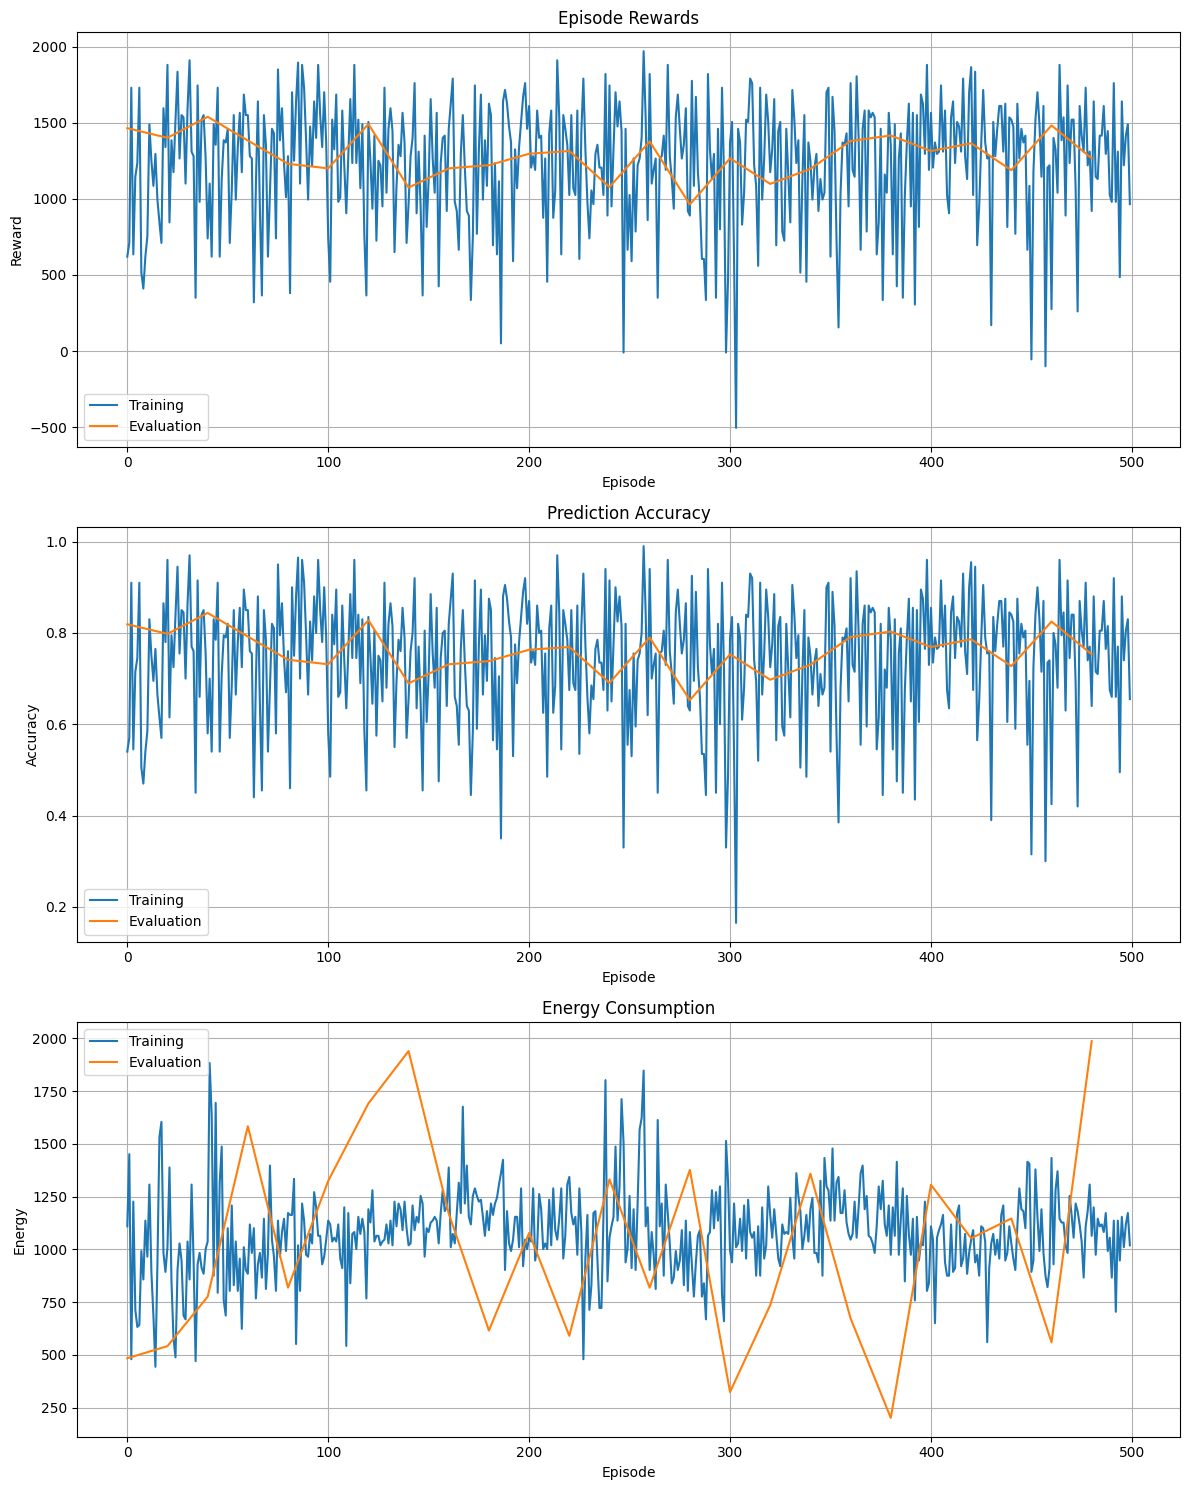

Final Evaluation Metrics:
  Reward: 1137.00
  Accuracy: 0.71
  Energy Consumption: 1997.40
Training completed and model saved.
Performing final evaluation...

Evaluation Results:
Average Reward: 1381.50 ± 340.27
Average Accuracy: 0.79 ± 0.11
Average Energy Consumption: 1992.00 ± 23.98


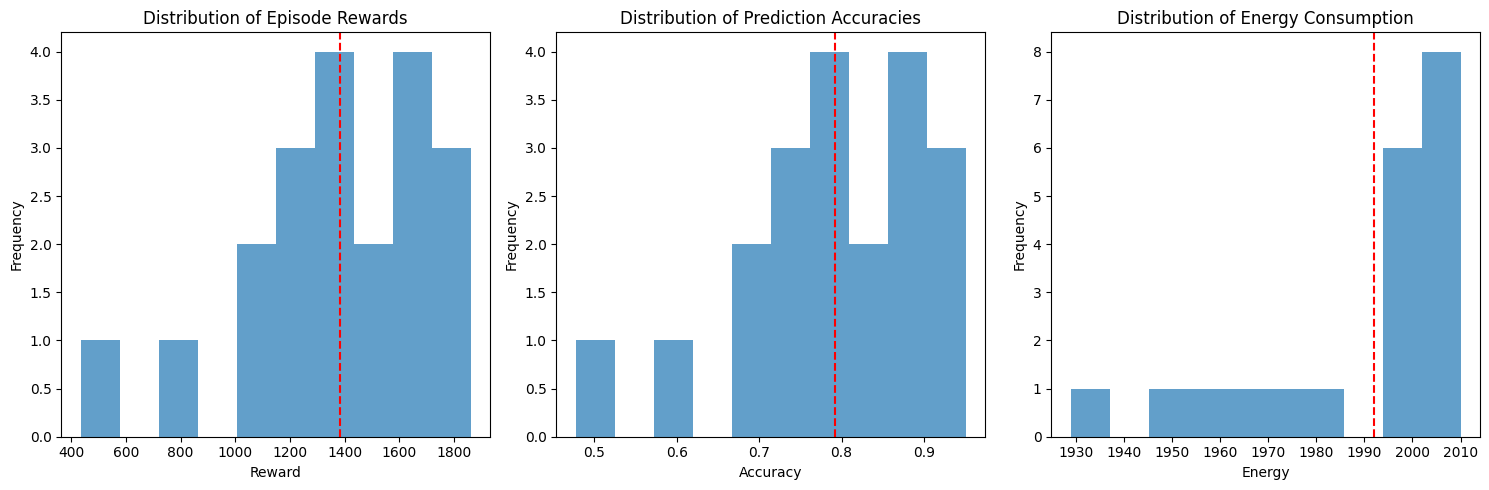

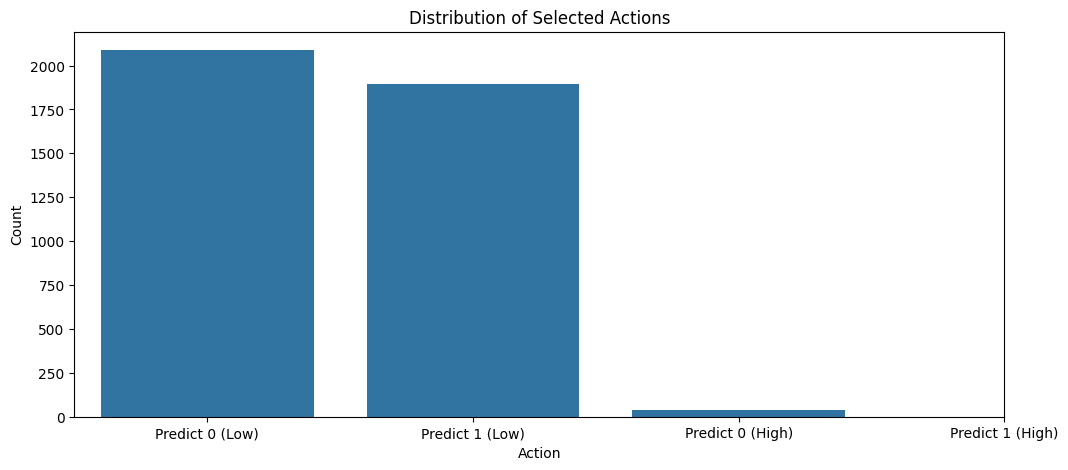

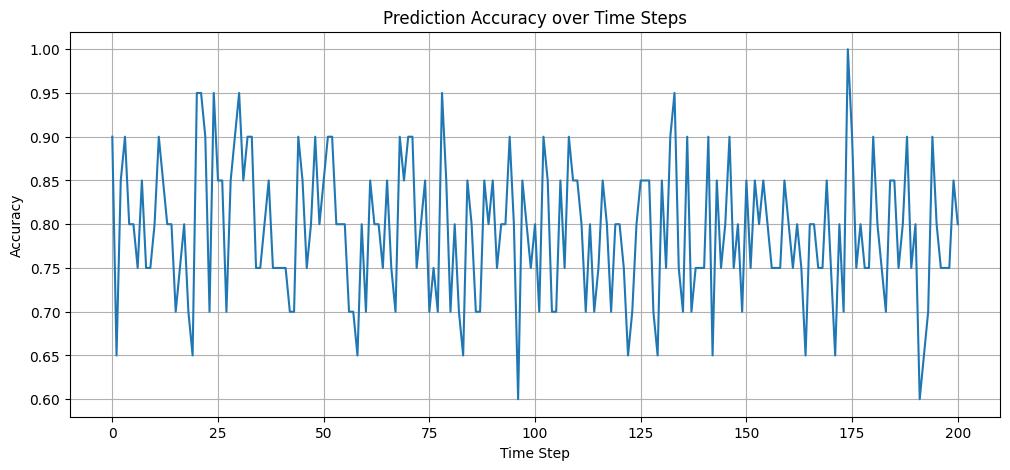

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns

# Import environment and DQN implementation
# (assuming they're already imported)
from environments import SBEOS_Environment

# Import DQN implementation from previous code
# In a real script, you would import these from a module
# from dqn_implementation import DQNAgent, train_dqn, evaluate_agent, plot_training_results

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

def train_and_evaluate_sbeos():
    """Train and evaluate DQN on the SBEOS environment"""
    print("Initializing SBEOS environment...")
    
    # Initialize environment
    env = SBEOS_Environment(
        max_timesteps=200,
        energy_cost=10,
        reward=10,
        penalty=5,
        pressure=0.1,
        window_size=10,
        time_dependence=4
    )
    
    # Reset environment to get state dimensions
    initial_state = env.reset()
    state_dim = len(initial_state)
    action_dim = 4  # 4 possible actions in SBEOS (0, 1 with low/high energy)
    
    print(f"State dimension: {state_dim}, Action dimension: {action_dim}")
    
    # Initialize DQN agent
    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=0.001,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.05,
        epsilon_decay=0.995,
        buffer_size=10000,
        batch_size=64,
        update_target_freq=200
    )
    
    # Train the agent
    print("Training DQN on SBEOS environment...")
    history = train_dqn(env, agent, num_episodes=500, eval_freq=20)
    
    # Plot training results
    plot_training_results(history)
    
    # Save the trained model
    agent.save_model("dqn_sbeos_model.pth")
    print("Training completed and model saved.")
    
    # Comprehensive evaluation
    print("Performing final evaluation...")
    test_env = SBEOS_Environment(
        max_timesteps=200,
        energy_cost=10,
        reward=10,
        penalty=5,
        pressure=0.1,
        window_size=10,
        time_dependence=4
    )
    
    # Evaluate with multiple episodes
    eval_episodes = 20
    rewards = []
    accuracies = []
    energy_consumption = []
    episode_data = []
    
    for episode in range(eval_episodes):
        state = test_env.reset()
        episode_reward = 0
        correct_predictions = 0
        total_predictions = 0
        energy_spent = 0
        step_data = []
        
        done = False
        step = 0
        
        while not done:
            # Get action from trained agent (no exploration)
            action = agent.get_action(state, training=False)
            
            # Take action in environment
            next_state, reward, done, info = test_env.step(action)
            
            # Update metrics
            episode_reward += reward
            energy_cost = info["energy_cost"]
            energy_spent += energy_cost
            
            # Track prediction accuracy
            is_correct = reward > 0
            if is_correct:
                correct_predictions += 1
            total_predictions += 1
            
            # Store step data
            step_data.append({
                "episode": episode,
                "step": step,
                "action": action,
                "reward": reward,
                "energy_cost": energy_cost,
                "correct_prediction": is_correct,
                "actual_state": info["state"]
            })
            
            # Move to next state
            state = next_state
            step += 1
        
        # Calculate episode accuracy
        episode_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        # Store episode metrics
        rewards.append(episode_reward)
        accuracies.append(episode_accuracy)
        energy_consumption.append(energy_spent)
        episode_data.extend(step_data)
    
    # Create DataFrame for detailed analysis
    df = pd.DataFrame(episode_data)
    
    # Print evaluation summary
    print("\nEvaluation Results:")
    print(f"Average Reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Average Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}")
    print(f"Average Energy Consumption: {np.mean(energy_consumption):.2f} ± {np.std(energy_consumption):.2f}")
    
    # Additional visualizations
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(rewards, bins=10, alpha=0.7)
    plt.axvline(np.mean(rewards), color='r', linestyle='--')
    plt.title('Distribution of Episode Rewards')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(accuracies, bins=10, alpha=0.7)
    plt.axvline(np.mean(accuracies), color='r', linestyle='--')
    plt.title('Distribution of Prediction Accuracies')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(energy_consumption, bins=10, alpha=0.7)
    plt.axvline(np.mean(energy_consumption), color='r', linestyle='--')
    plt.title('Distribution of Energy Consumption')
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Action distribution analysis
    plt.figure(figsize=(12, 5))
    sns.countplot(x='action', data=df)
    plt.title('Distribution of Selected Actions')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks([0, 1, 2, 3], ['Predict 0 (Low)', 'Predict 1 (Low)', 'Predict 0 (High)', 'Predict 1 (High)'])
    plt.show()
    
    # Accuracy over time
    plt.figure(figsize=(12, 5))
    df_grouped = df.groupby('step')['correct_prediction'].mean().reset_index()
    plt.plot(df_grouped['step'], df_grouped['correct_prediction'])
    plt.title('Prediction Accuracy over Time Steps')
    plt.xlabel('Time Step')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    return agent, history, df

def train_and_evaluate_multiband_sbeos():
    """Train and evaluate DQN on the MultiBandSBEOS environment"""
    print("Initializing MultiBandSBEOS environment...")
    
    # Number of bands
    num_bands = 3
    
    # Initialize environment
    env = MultiBandSBEOS(
        num_bands=num_bands,
        max_timesteps=200,
        energy_cost=10,
        reward=10,
        penalty=5,
        pressure=0.1,
        window_size=10,
        time_dependence=4
    )
    
    # Reset environment to get state dimensions
    initial_state = env.reset()
    state_dim = len(initial_state)
    action_dim = 4 * num_bands  # 4 possible actions per band
    
    print(f"State dimension: {state_dim}, Action dimension: {action_dim}")
    
    # Initialize DQN agent
    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=0.001,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.05,
        epsilon_decay=0.997,  # Slower decay for more complex environment
        buffer_size=20000,
        batch_size=128,
        update_target_freq=300
    )
    
    # Train the agent
    print("Training DQN on MultiBandSBEOS environment...")
    history = train_dqn(env, agent, num_episodes=800, eval_freq=40)
    
    # Plot training results
    plot_training_results(history)
    
    # Save the trained model
    agent.save_model("dqn_multiband_sbeos_model.pth")
    print("Training completed and model saved.")
    
    # Comprehensive evaluation
    print("Performing final evaluation...")
    test_env = MultiBandSBEOS(
        num_bands=num_bands,
        max_timesteps=200,
        energy_cost=10,
        reward=10,
        penalty=5,
        pressure=0.1,
        window_size=10,
        time_dependence=4
    )
    
    # Evaluate with multiple episodes
    eval_episodes = 20
    rewards = []
    accuracies = []
    energy_consumption = []
    episode_data = []
    
    for episode in range(eval_episodes):
        state = test_env.reset()
        episode_reward = 0
        correct_predictions = 0
        total_predictions = 0
        energy_spent = 0
        step_data = []
        
        done = False
        step = 0
        
        while not done:
            # Get action from trained agent (no exploration)
            action = agent.get_action(state, training=False)
            
            # Take action in environment
            next_state, reward, done, info = test_env.step(action)
            
            # Update metrics
            episode_reward += reward
            energy_cost = info["energy_cost"]
            transition_cost = info.get("transition_cost", 0)
            energy_spent += energy_cost + transition_cost
            
            # Track prediction accuracy
            is_correct = reward > 0
            if is_correct:
                correct_predictions += 1
            total_predictions += 1
            
            # Store step data
            step_data.append({
                "episode": episode,
                "step": step,
                "action": action,
                "selected_band": info.get("selected_band", action // 4),
                "reward": reward,
                "energy_cost": energy_cost,
                "transition_cost": transition_cost,
                "correct_prediction": is_correct,
                "actual_state": info.get("actual_state", None)
            })
            
            # Move to next state
            state = next_state
            step += 1
        
        # Calculate episode accuracy
        episode_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        # Store episode metrics
        rewards.append(episode_reward)
        accuracies.append(episode_accuracy)
        energy_consumption.append(energy_spent)
        episode_data.extend(step_data)
    
    # Create DataFrame for detailed analysis
    df = pd.DataFrame(episode_data)
    
    # Print evaluation summary
    print("\nEvaluation Results:")
    print(f"Average Reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Average Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}")
    print(f"Average Energy Consumption: {np.mean(energy_consumption):.2f} ± {np.std(energy_consumption):.2f}")
    
    # Additional visualizations
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(rewards, bins=10, alpha=0.7)
    plt.axvline(np.mean(rewards), color='r', linestyle='--')
    plt.title('Distribution of Episode Rewards')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(accuracies, bins=10, alpha=0.7)
    plt.axvline(np.mean(accuracies), color='r', linestyle='--')
    plt.title('Distribution of Prediction Accuracies')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(energy_consumption, bins=10, alpha=0.7)
    plt.axvline(np.mean(energy_consumption), color='r', linestyle='--')
    plt.title('Distribution of Energy Consumption')
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Band selection analysis
    plt.figure(figsize=(10, 5))
    sns.countplot(x='selected_band', data=df)
    plt.title('Distribution of Selected Bands')
    plt.xlabel('Band')
    plt.ylabel('Count')
    plt.show()
    
    # Energy cost breakdown
    plt.figure(figsize=(12, 5))
    df_grouped = df.groupby('episode').agg({
        'energy_cost': 'sum',
        'transition_cost': 'sum'
    }).reset_index()
    
    plt.bar(df_grouped['episode'], df_grouped['energy_cost'], label='Action Energy')
    plt.bar(df_grouped['episode'], df_grouped['transition_cost'], bottom=df_grouped['energy_cost'], label='Transition Energy')
    plt.title('Energy Cost Breakdown by Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Energy')
    plt.legend()
    plt.show()
    
    return agent, history, df

if __name__ == "__main__":
    # Run training for single-band SBEOS
    agent_sbeos, history_sbeos, df_sbeos = train_and_evaluate_sbeos()
    
    # Run training for multi-band SBEOS (uncomment to run)
    # agent_multiband, history_multiband, df_multiband = train_and_evaluate_multiband_sbeos()

Creating test environment...
State dimension from test environment: 16, Action dimension: 4
Loading trained model...
Evaluating agent on test environment...


Evaluating episodes: 100%|██████████| 50/50 [00:05<00:00,  8.95it/s]


Overall Accuracy: 0.8146
Precision: 0.8087
Recall: 0.8022
F1 Score: 0.8054
Average Reward per Step: 5.2193
Average Energy Cost per Step: 11.9031

===== OVERALL EVALUATION METRICS =====
Accuracy: 0.8146
Precision: 0.8087
Recall: 0.8022
F1 Score: 0.8054

Plotting evaluation results...


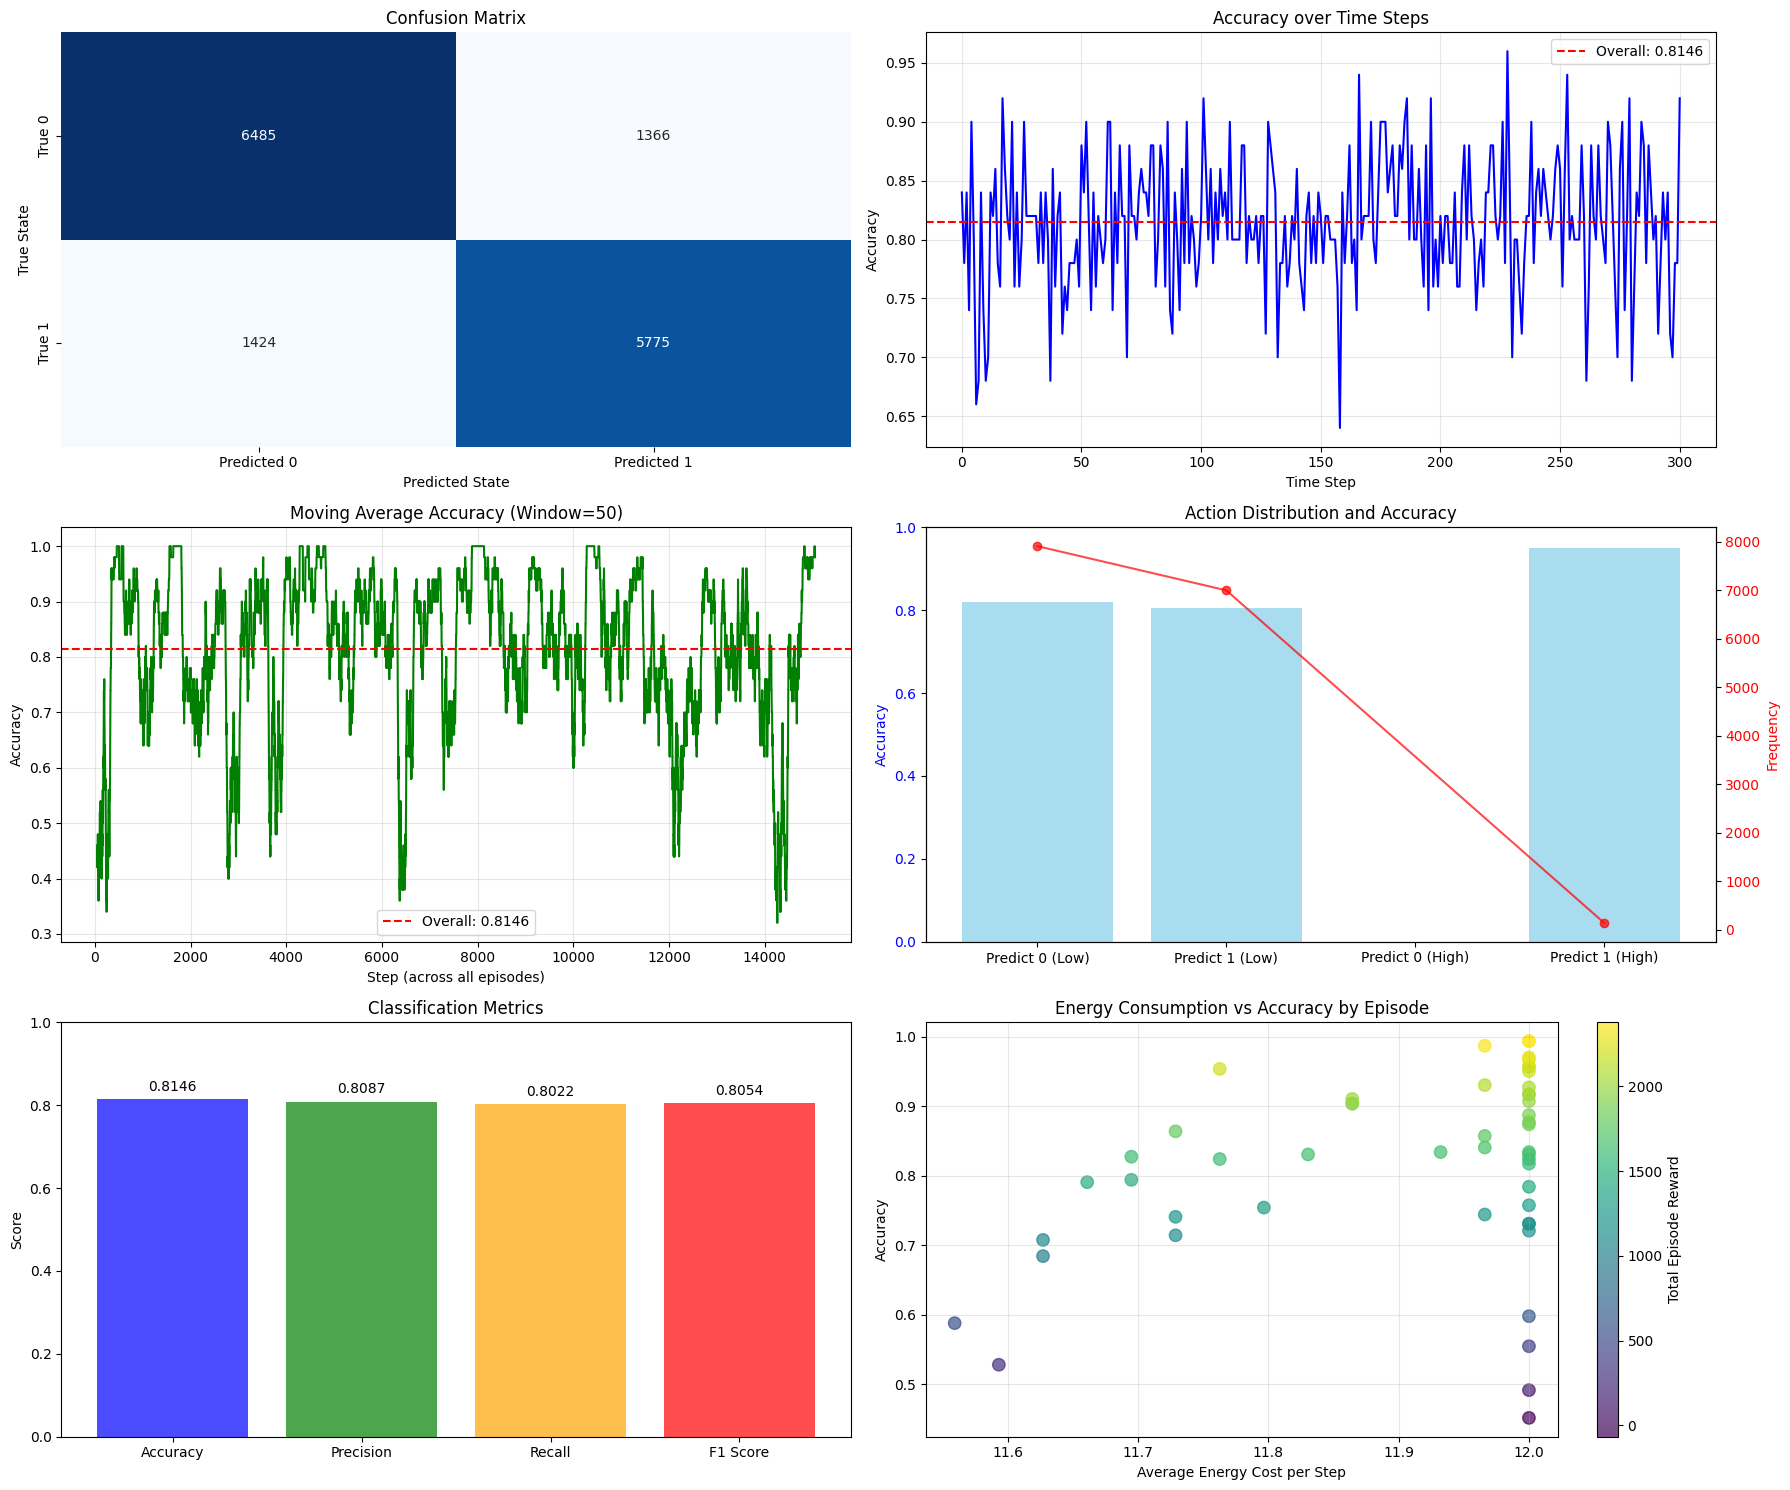

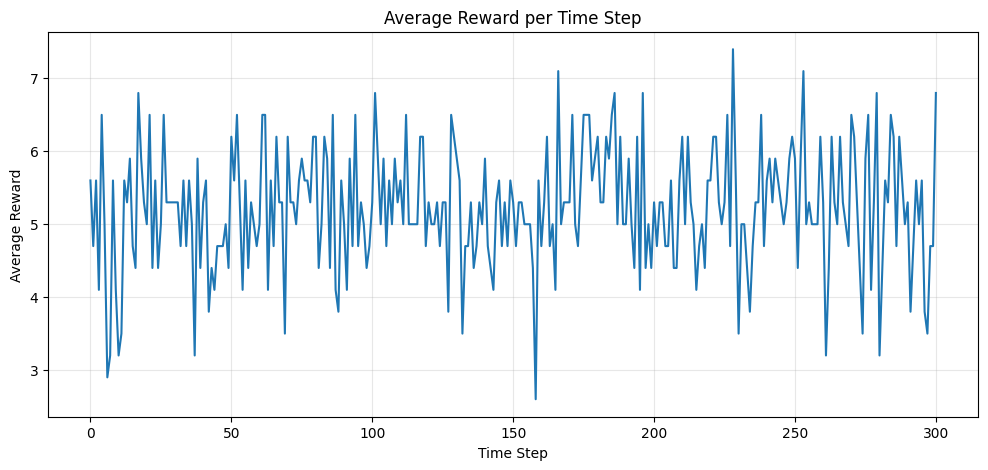

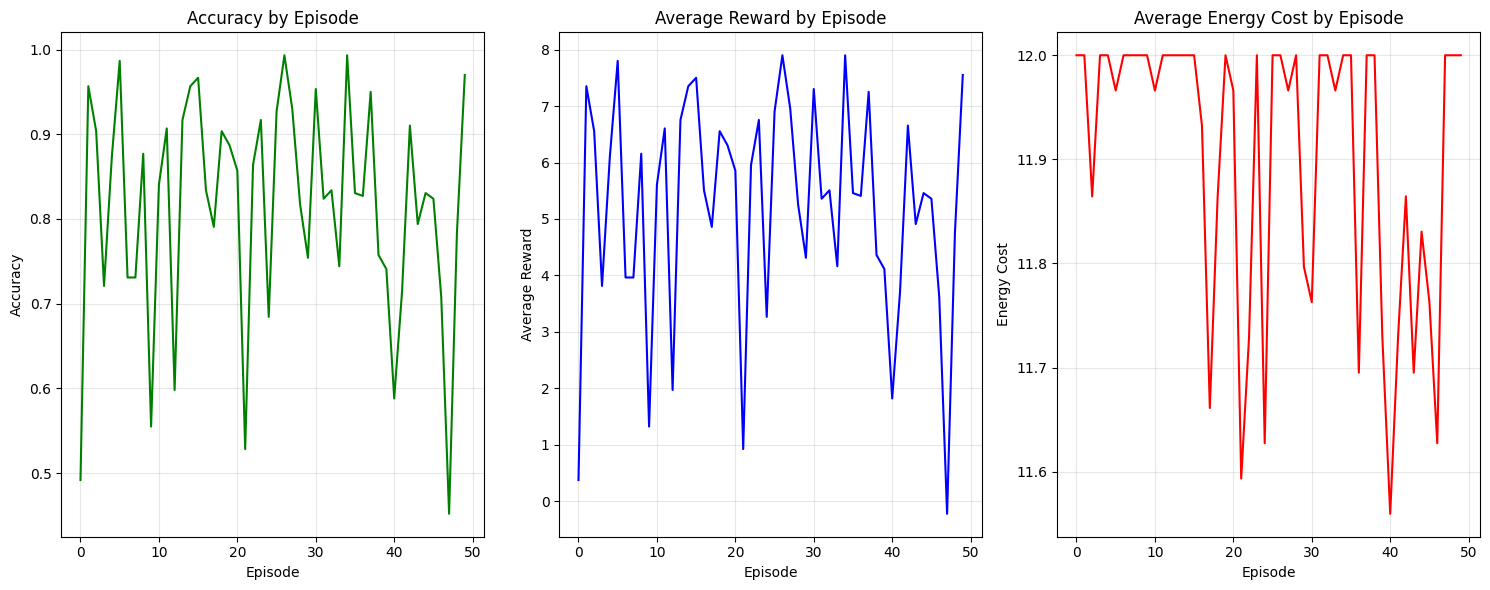

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Import environment and DQN implementation
# (assuming they're already imported)
from environments import SBEOS_Environment

# Import DQN implementation from previous code
# In a real script, you would import these from a module
# from dqn_implementation import DQNAgent

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

def create_test_environment():
    """Create a test environment with different parameters to evaluate generalization"""
    # Keep the same state dimension as training for model compatibility
    # but vary other parameters to test generalization
    test_env = SBEOS_Environment(
        max_timesteps=300,  # Longer episode length
        energy_cost=12,     # Higher energy cost
        reward=8,           # Lower reward
        penalty=7,          # Higher penalty
        pressure=0.15,      # Different pressure parameter
        window_size=10,     # KEEP SAME as training to maintain state dimension
        time_dependence=4   # KEEP SAME as training to maintain state dimension
    )
    return test_env

def evaluate_agent_detailed(agent, env, num_episodes=50):
    """Perform detailed evaluation of the agent on the given environment"""
    all_predictions = []
    all_true_values = []
    rewards_over_time = []
    accuracies_over_time = []
    energy_over_time = []
    episode_data = []
    
    # Check if state adaptation is needed
    state_adaptation_needed = hasattr(agent, 'state_dim') and agent.state_dim != len(env.reset())
    
    if state_adaptation_needed:
        print(f"Adapting states: Agent expects {agent.state_dim} features, environment provides {len(env.reset())}")
    
    def adapt_state(state):
        """Adapt state to match model's expected dimension if needed"""
        if not state_adaptation_needed:
            return state
        
        # Simple adaptation strategy: truncate or pad with zeros
        if len(state) > agent.state_dim:
            # Truncate to expected size
            return state[:agent.state_dim]
        elif len(state) < agent.state_dim:
            # Pad with zeros
            padded = np.zeros(agent.state_dim)
            padded[:len(state)] = state
            return padded
        return state
    
    for episode in tqdm(range(num_episodes), desc="Evaluating episodes"):
        state = env.reset()
        state = adapt_state(state)  # Adapt initial state if needed
        
        episode_reward = 0
        step_rewards = []
        step_accuracies = []
        step_energy = []
        
        done = False
        step = 0
        
        while not done:
            # Get action from trained agent (no exploration)
            action = agent.get_action(state, training=False)
            
            # Take action in environment
            next_state, reward, done, info = env.step(action)
            next_state = adapt_state(next_state)  # Adapt next state if needed
            
            # Update metrics
            episode_reward += reward
            energy_cost = info["energy_cost"]
            
            # Extract the agent's prediction and the true state
            predicted_state = 1 if action % 2 == 1 else 0  # Extract prediction from action
            true_state = info["state"]
            
            # Store for confusion matrix
            all_predictions.append(predicted_state)
            all_true_values.append(true_state)
            
            # Store step data
            step_rewards.append(reward)
            step_accuracies.append(1 if predicted_state == true_state else 0)
            step_energy.append(energy_cost)
            
            # Store detailed step data
            episode_data.append({
                "episode": episode,
                "step": step,
                "action": action,
                "predicted_state": predicted_state,
                "true_state": true_state,
                "reward": reward,
                "energy_cost": energy_cost,
                "is_correct": predicted_state == true_state
            })
            
            # Move to next state
            state = next_state
            step += 1
        
        # Track metrics over all episodes
        rewards_over_time.append(step_rewards)
        accuracies_over_time.append(step_accuracies)
        energy_over_time.append(step_energy)
    
    # Create DataFrame for analysis
    df = pd.DataFrame(episode_data)
    
    # Create confusion matrix
    cm = confusion_matrix(all_true_values, all_predictions)
    
    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_true_values, all_predictions)
    
    # Calculate precision, recall, and F1 score
    precision = precision_score(all_true_values, all_predictions, zero_division=0)
    recall = recall_score(all_true_values, all_predictions, zero_division=0)
    f1 = f1_score(all_true_values, all_predictions, zero_division=0)
    
    # Flatten the list of lists to calculate average metrics
    all_rewards = [item for sublist in rewards_over_time for item in sublist]
    all_accuracies = [item for sublist in accuracies_over_time for item in sublist]
    all_energy = [item for sublist in energy_over_time for item in sublist]
    
    # Calculate average metrics
    avg_reward = np.mean(all_rewards)
    avg_accuracy = np.mean(all_accuracies)
    avg_energy = np.mean(all_energy)
    
    # Print all evaluation metrics
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average Reward per Step: {avg_reward:.4f}")
    print(f"Average Energy Cost per Step: {avg_energy:.4f}")
    
    return {
        "confusion_matrix": cm,
        "overall_accuracy": overall_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "rewards_over_time": rewards_over_time,
        "accuracies_over_time": accuracies_over_time,
        "energy_over_time": energy_over_time,
        "df": df
    }

def plot_evaluation_results(eval_results):
    """Plot evaluation results including confusion matrix, accuracy, precision, recall, and F1 score"""
    cm = eval_results["confusion_matrix"]
    df = eval_results["df"]
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(18, 15))
    
    # 1. Plot confusion matrix
    plt.subplot(3, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix')
    plt.ylabel('True State')
    plt.xlabel('Predicted State')
    
    # 2. Plot accuracy over time steps (averaged across episodes)
    plt.subplot(3, 2, 2)
    step_accuracy = df.groupby('step')['is_correct'].mean()
    plt.plot(step_accuracy.index, step_accuracy.values, 'b-')
    plt.axhline(y=eval_results["overall_accuracy"], color='r', linestyle='--', 
                label=f'Overall: {eval_results["overall_accuracy"]:.4f}')
    plt.title('Accuracy over Time Steps')
    plt.xlabel('Time Step')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Plot moving average of accuracy across all episodes
    plt.subplot(3, 2, 3)
    accuracy_window = 50  # Window size for moving average
    moving_acc = df['is_correct'].rolling(window=accuracy_window).mean()
    plt.plot(moving_acc, 'g-')
    plt.axhline(y=eval_results["overall_accuracy"], color='r', linestyle='--',
                label=f'Overall: {eval_results["overall_accuracy"]:.4f}')
    plt.title(f'Moving Average Accuracy (Window={accuracy_window})')
    plt.xlabel('Step (across all episodes)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Plot distribution of actions with accuracy
    plt.subplot(3, 2, 4)
    action_accuracy = df.groupby('action')['is_correct'].mean().reset_index()
    action_counts = df['action'].value_counts().reset_index()
    action_counts.columns = ['action', 'count']
    action_data = pd.merge(action_accuracy, action_counts, on='action')
    
    # Create bar plot with two y-axes
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot accuracy bars
    bars = ax1.bar(action_data['action'], action_data['is_correct'], alpha=0.7, color='skyblue')
    ax1.set_ylim(0, 1)
    ax1.set_ylabel('Accuracy', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Add count line
    line = ax2.plot(action_data['action'], action_data['count'], 'r-o', alpha=0.7)
    ax2.set_ylabel('Frequency', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.title('Action Distribution and Accuracy')
    plt.xlabel('Action (0-3)')
    plt.xticks([0, 1, 2, 3], ['Predict 0 (Low)', 'Predict 1 (Low)', 'Predict 0 (High)', 'Predict 1 (High)'])
    
    # 5. Plot precision, recall, and F1 score bar graph
    plt.subplot(3, 2, 5)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [eval_results['overall_accuracy'], eval_results['precision'], 
              eval_results['recall'], eval_results['f1_score']]
    
    colors = ['blue', 'green', 'orange', 'red']
    plt.bar(metrics, values, color=colors, alpha=0.7)
    plt.ylim(0, 1)
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    
    # Add value labels on top of bars
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
    
    # 6. Plot energy consumption vs accuracy
    plt.subplot(3, 2, 6)
    
    # Group by episode
    episode_metrics = df.groupby('episode').agg({
        'is_correct': 'mean',
        'energy_cost': 'mean',
        'reward': 'sum'
    }).reset_index()
    
    plt.scatter(episode_metrics['energy_cost'], episode_metrics['is_correct'], 
                c=episode_metrics['reward'], cmap='viridis', s=80, alpha=0.7)
    
    plt.colorbar(label='Total Episode Reward')
    plt.title('Energy Consumption vs Accuracy by Episode')
    plt.xlabel('Average Energy Cost per Step')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional plots
    
    # 7. Plot reward over time
    plt.figure(figsize=(12, 5))
    step_reward = df.groupby('step')['reward'].mean()
    plt.plot(step_reward.index, step_reward.values)
    plt.title('Average Reward per Time Step')
    plt.xlabel('Time Step')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 8. Plot metrics by episode
    plt.figure(figsize=(15, 6))
    
    # Calculate metrics per episode
    episode_metrics = df.groupby('episode').agg({
        'is_correct': 'mean',  # Accuracy
        'reward': 'mean',      # Average reward
        'energy_cost': 'mean'  # Average energy cost
    }).reset_index()
    
    plt.subplot(1, 3, 1)
    plt.plot(episode_metrics['episode'], episode_metrics['is_correct'], 'g-')
    plt.title('Accuracy by Episode')
    plt.xlabel('Episode')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(episode_metrics['episode'], episode_metrics['reward'], 'b-')
    plt.title('Average Reward by Episode')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.plot(episode_metrics['episode'], episode_metrics['energy_cost'], 'r-')
    plt.title('Average Energy Cost by Episode')
    plt.xlabel('Episode')
    plt.ylabel('Energy Cost')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def load_trained_model(model_path, state_dim, action_dim):
    """Load a previously trained model from file"""
    try:
        # First, try to create an agent with the current state_dim
        agent = DQNAgent(
            state_dim=state_dim,
            action_dim=action_dim,
            lr=0.001,
            gamma=0.99,
            epsilon=0.05,  # Low epsilon for evaluation
            epsilon_min=0.05,
            epsilon_decay=1.0,  # No decay during evaluation
            buffer_size=10000,
            batch_size=64,
            update_target_freq=200
        )
        agent.load_model(model_path)
        return agent
    except RuntimeError as e:
        print(f"Error loading model: {e}")
        print("Attempting to determine correct state_dim from saved model...")
        
        # Try to extract the state dimension from the error message
        # Look for patterns like "shape torch.Size([128, 16])" in the error message
        error_str = str(e)
        
        # Look for the input dimension in the saved model
        import re
        match = re.search(r'copying a param with shape torch\.Size\(\[128, (\d+)\]\)', error_str)
        
        if match:
            saved_state_dim = int(match.group(1))
            print(f"Detected saved_state_dim={saved_state_dim}, recreating agent with this dimension")
            
            # Create new agent with the correct state dimension
            agent = DQNAgent(
                state_dim=saved_state_dim,
                action_dim=action_dim,
                lr=0.001,
                gamma=0.99,
                epsilon=0.05,
                epsilon_min=0.05,
                epsilon_decay=1.0,
                buffer_size=10000,
                batch_size=64,
                update_target_freq=200
            )
            
            # Try loading the model again
            agent.load_model(model_path)
            print("Model loaded successfully with adjusted state_dim")
            
            # Return the agent and the correct state_dim
            return agent
        else:
            raise Exception("Could not determine correct state dimension from error message")

def evaluate_on_test_environment():
    """Main function to evaluate a trained agent on a test environment"""
    print("Creating test environment...")
    test_env = create_test_environment()
    
    # Get state dimensions from environment
    initial_state = test_env.reset()
    state_dim = len(initial_state)
    action_dim = 4  # 4 possible actions in SBEOS
    
    print(f"State dimension from test environment: {state_dim}, Action dimension: {action_dim}")
    
    # Load trained model
    print("Loading trained model...")
    agent = load_trained_model("dqn_sbeos_model.pth", state_dim, action_dim)
    
    # Check if we need to adapt the state
    if hasattr(agent, 'state_dim') and agent.state_dim != state_dim:
        print(f"WARNING: Model expects state_dim={agent.state_dim}, but environment provides state_dim={state_dim}")
        print("Will adapt states during evaluation")
    
    # Evaluate agent on test environment
    print("Evaluating agent on test environment...")
    eval_results = evaluate_agent_detailed(agent, test_env, num_episodes=50)
    
    # Print overall metrics in a structured format
    print("\n===== OVERALL EVALUATION METRICS =====")
    print(f"Accuracy: {eval_results['overall_accuracy']:.4f}")
    print(f"Precision: {eval_results['precision']:.4f}")
    print(f"Recall: {eval_results['recall']:.4f}")
    print(f"F1 Score: {eval_results['f1_score']:.4f}")
    print("======================================\n")
    
    # Plot results
    print("Plotting evaluation results...")
    plot_evaluation_results(eval_results)
    
    return eval_results

if __name__ == "__main__":
    # Run evaluation on test environment
    eval_results = evaluate_on_test_environment()